In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
aug_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/augmented_testing_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [3]:

# Convert Timestamp columns to datetime (very important for time operations)
for df in [aug_train, aug_test, org_train, org_test]:
    df['Timestamp'] = pd.to_datetime(df['Time'])

In [4]:
# =========================
# Lag + Rolling Feature Engineering

def generate_lag_and_rolling_features(df, lags_dict, rolling_windows):
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Timestamp')  # time sort within location
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

# =========================
# Lag + Rolling Feature Engineering (Timestamp → AugType → Location sorting)

def generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows):
    df = df.copy()
    
    # First sort globally by Timestamp, AugmentationType, then Location
    df = df.sort_values(['Timestamp', 'augmented', 'Location']).reset_index(drop=True)
    
    all_groups = []
    
    # Group by (AugmentationType, Location) — after global sorting
    for (aug_type, loc), group in df.groupby(['augmented', 'Location']):
        group = group.sort_values('Timestamp')  # ensure strict time order within each subgroup
        
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged




def add_time_features(df):
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['month'] = df['Timestamp'].dt.month
    
    df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def scale_features(df, scaler=None, feature_cols=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[feature_cols])
    else:
        scaled_values = scaler.transform(df[feature_cols])

    df_scaled = df.copy()
    df_scaled[feature_cols] = scaled_values
    return df_scaled, scaler

In [5]:
# =========================
# Complete Pipeline Function

def full_preprocessing_pipeline(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

# =========================
# Complete Pipeline Function for augmented data

def full_preprocessing_pipeline_for_aug(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

In [6]:
# =========================
# Setup lags and rolling windows

lags_dict = {
    'Power': [1, 3, 6, 12, 24],
    'windspeed_10m': [1, 3, 6, 24],
    'windspeed_100m': [1, 3, 6, 24],
    'windgusts_10m': [1, 3, 6, 24],
}

rolling_windows = [3, 6, 12, 24]

# =========================
# Apply pipeline

# ORIGINAL DATA
org_train_processed, org_scaler = full_preprocessing_pipeline(org_train, lags_dict, rolling_windows)
org_test_processed, _           = full_preprocessing_pipeline(org_test, lags_dict, rolling_windows)

# AUGMENTED DATA
aug_train_processed, aug_scaler = full_preprocessing_pipeline_for_aug(aug_train, lags_dict, rolling_windows)
# aug_test_processed, _           = full_preprocessing_pipeline_for_aug(aug_test, lags_dict, rolling_windows)

print("All datasets processed successfully!")


All datasets processed successfully!


In [7]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power_lag1', 'Power_lag3',
       'Power_lag6', 'Power_lag12', 'Power_lag24', 'windspeed_10m_lag1',
       'windspeed_10m_lag3', 'windspeed_10m_lag6', 'windspeed_10m_lag24',
       'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
       'windspeed_100m_lag24', 'windgusts_10m_lag1', 'windgusts_10m_lag3',
       'windgusts_10m_lag6', 'windgusts_10m_lag24', 'Power_roll_mean_3',
       'Power_roll_std_3', 'windspeed_10m_roll_mean_3',
       'windspeed_10m_roll_std_3', 'windspeed_100m_roll_mean_3',
       'windspeed_100m_roll_std_3', 'windgusts_10m_roll_mean_3',
       'windgusts_10m_roll_std_3', 'Power_roll_mean_6', 'Power_roll_std_6',
       'windspeed_10m_roll_mean_6', 'windspeed_10m_roll_std_6',
       'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6',
       'windgusts_10m_roll_mean_6', 'windgusts_10m_roll_std_6',
       'Power_roll_mean_12', 'Power_roll_std_12', 'windspeed_10m_roll_mean_12',
       'windspeed_10m_roll_std_12', 'windspeed_100m_roll_mean_12',
       'windspeed_100m_roll_std_12', 'windgusts_10m_roll_mean_12',
       'windgusts_10m_roll_std_12', 'Power_roll_mean_24', 'Power_roll_std_24',
       'windspeed_10m_roll_mean_24', 'windspeed_10m_roll_std_24',
       'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24',
       'windgusts_10m_roll_mean_24', 'windgusts_10m_roll_std_24'
]
target = 'Power'

In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:

# ------------------ PatchTST Model ------------------
class PatchTST(nn.Module):
    def __init__(self, seq_len, n_features, patch_len, forecast_horizon, d_model=128, n_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.patch_len = patch_len
        self.n_patches = seq_len // patch_len
        self.d_model = d_model

        self.patch_embed = nn.Linear(patch_len * n_features, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, self.n_patches, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_layer = nn.Linear(d_model, forecast_horizon)

    def forward(self, x):
        B = x.shape[0]
        x = x.unfold(dimension=1, size=self.patch_len, step=self.patch_len)  
        x = x.contiguous().view(B, self.n_patches, -1)
        x = self.patch_embed(x)
        x = x + self.pos_encoding
        x = self.transformer(x)
        x = x.mean(dim=1)
        out = self.output_layer(x)
        return out


In [10]:
# ------------------ Dataset Preparation ------------------
def create_sequences(X_data, y_data, seq_len, forecast_horizon):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - seq_len - forecast_horizon):
        X_seq.append(X_data.iloc[i:i+seq_len].values)
        y_seq.append(y_data.iloc[i+seq_len:i+seq_len+forecast_horizon].values)
    return np.array(X_seq), np.array(y_seq)

# ------------------ Desequencing Function ------------------
def desequence(predictions, seq_len, forecast_horizon):
    total_length = len(predictions) + seq_len + forecast_horizon - 1
    merged_forecast = np.zeros(total_length)
    count = np.zeros(total_length)

    for i in range(len(predictions)):
        start_idx = i + seq_len
        end_idx = start_idx + forecast_horizon
        merged_forecast[start_idx:end_idx] += predictions[i]
        count[start_idx:end_idx] += 1

    nonzero_mask = count != 0
    merged_forecast[nonzero_mask] /= count[nonzero_mask]

    return merged_forecast

In [11]:
seq_len = 24
forecast_horizon = 12
patch_len = 4

X_train_org = org_train_processed[features]
y_train_org = org_train_processed[target]

X_test = org_test_processed[features].copy()
X_test.index = pd.to_datetime(org_test_processed["Time"])
y_test = org_test_processed[target]

In [12]:
# ------------------ Updated Evaluation Function ------------------
def evaluate_two_models(
    model_orig, model_aug, scaler, X_test, y_test, features, 
    seq_len, forecast_horizon, patch_len, time_index=None, 
    start_point=0, end_point=None
):
    # Scale test data
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)
    X_seq, y_seq = create_sequences(X_test_scaled, y_test, seq_len, forecast_horizon)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    
    # Get predictions from original model
    model_orig.eval()
    with torch.no_grad():
        preds_orig = model_orig(X_tensor).numpy()
    merged_pred_orig = desequence(preds_orig, seq_len, forecast_horizon)

    # Get predictions from augmented model
    model_aug.eval()
    with torch.no_grad():
        preds_aug = model_aug(X_tensor).numpy()
    merged_pred_aug = desequence(preds_aug, seq_len, forecast_horizon)
    
    # Get true values
    merged_true = desequence(y_seq, seq_len, forecast_horizon)
    
    # Apply slicing
    merged_true = merged_true[start_point:end_point]
    merged_pred_orig = merged_pred_orig[start_point:end_point]
    merged_pred_aug = merged_pred_aug[start_point:end_point]

    # Metrics for both models
    mse_orig = mean_squared_error(merged_true, merged_pred_orig)
    mae_orig = mean_absolute_error(merged_true, merged_pred_orig)
    rmse_orig = math.sqrt(mse_orig)

    mse_aug = mean_squared_error(merged_true, merged_pred_aug)
    mae_aug = mean_absolute_error(merged_true, merged_pred_aug)
    rmse_aug = math.sqrt(mse_aug)

    print(f"Original Model - MSE: {mse_orig:.4f}, MAE: {mae_orig:.4f}, RMSE: {rmse_orig:.4f}")
    print(f"Augmented Model - MSE: {mse_aug:.4f}, MAE: {mae_aug:.4f}, RMSE: {rmse_aug:.4f}")

    if time_index is not None:
        time_index = time_index[-len(merged_true):]
        plot_range = time_index
    else:
        plot_range = range(len(merged_true))

    # Plot
    plt.figure(figsize=(16, 6))
    plt.plot(plot_range, merged_true, label='Actual', color='black', linewidth=2)
    plt.plot(plot_range, merged_pred_orig, label='Original Model Forecast', color='red', linestyle='--')
    plt.plot(plot_range, merged_pred_aug, label='Augmented Model Forecast', color='blue', linestyle=':')

    # Fill area between Actual and Original Model
    plt.fill_between(
        plot_range, merged_true, merged_pred_orig, 
        where=(merged_true > merged_pred_orig), 
        interpolate=True, color='pink', alpha=0.5, label='Error (Actual - Original)'
    )
    plt.fill_between(
        plot_range, merged_pred_orig, merged_true, 
        where=(merged_true <= merged_pred_orig), 
        interpolate=True, color='pink', alpha=0.5
    )

    # Fill area between Original Model and Augmented Model
    plt.fill_between(
        plot_range, merged_pred_orig, merged_pred_aug, 
        where=(merged_pred_aug > merged_pred_orig), 
        interpolate=True, color='lightblue', alpha=0.5, label='Difference (Original - Augmented)'
    )
    plt.fill_between(
        plot_range, merged_pred_aug, merged_pred_orig, 
        where=(merged_pred_aug <= merged_pred_orig), 
        interpolate=True, color='lightblue', alpha=0.5
    )

    plt.xlabel("Date" if time_index is not None else "Steps")
    plt.ylabel("Power")
    plt.title("Forecast Comparison: Original vs Augmented Model")
    plt.legend()
    plt.grid(True)
    
    # Show metrics in plot
    textstr = (
        f'Original Model\nMAE: {mae_orig:.4f}\nRMSE: {rmse_orig:.4f}\n'
        f'Augmented Model\nMAE: {mae_aug:.4f}\nRMSE: {rmse_aug:.4f}'
    )
    plt.gcf().text(0.75, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.show()


In [13]:
import joblib

In [14]:
model_patchtst  =PatchTST(seq_len, len(features), patch_len, forecast_horizon)
# Load model state_dict
model_path  = "../Models/weights/patchtst_model.pth"
model_patchtst.load_state_dict(torch.load(model_path))

# Set model to eval mode (important for inference)
model_patchtst.eval()

print("Model loaded successfully.")

Model loaded successfully.


In [15]:
model_patchtst_aug  =PatchTST(seq_len, len(features), patch_len, forecast_horizon)
# Load model state_dict
model_path  = "../Models/weights/patchtst_model_aug.pth"
model_patchtst_aug.load_state_dict(torch.load(model_path))

# Set model to eval mode (important for inference)
model_patchtst_aug.eval()

print("Model loaded successfully.")

scaler_path = '../Models/weights/patchtst_scaler_aug.pkl'
scaler_patchtst_aug = joblib.load(scaler_path)

print("Scaler loaded successfully.")

Model loaded successfully.
Scaler loaded successfully.



Evaluating PatchTST on test data...
Original Model - MSE: 0.0268, MAE: 0.1329, RMSE: 0.1637
Augmented Model - MSE: 0.0251, MAE: 0.1250, RMSE: 0.1585


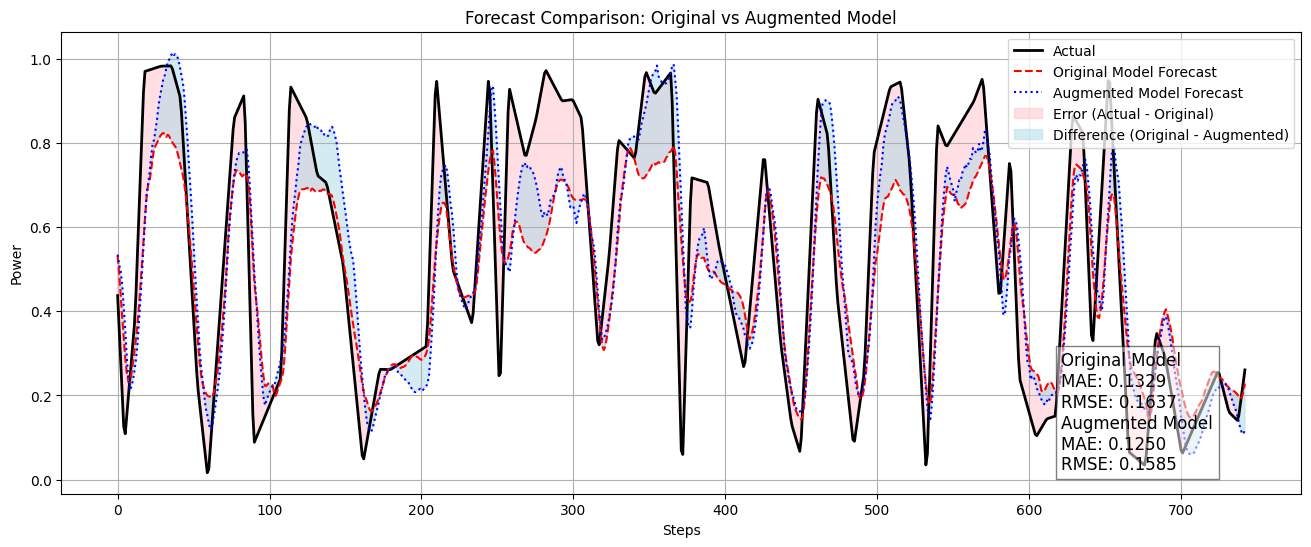

Original Model - MSE: 0.0124, MAE: 0.0893, RMSE: 0.1114
Augmented Model - MSE: 0.0129, MAE: 0.0879, RMSE: 0.1134


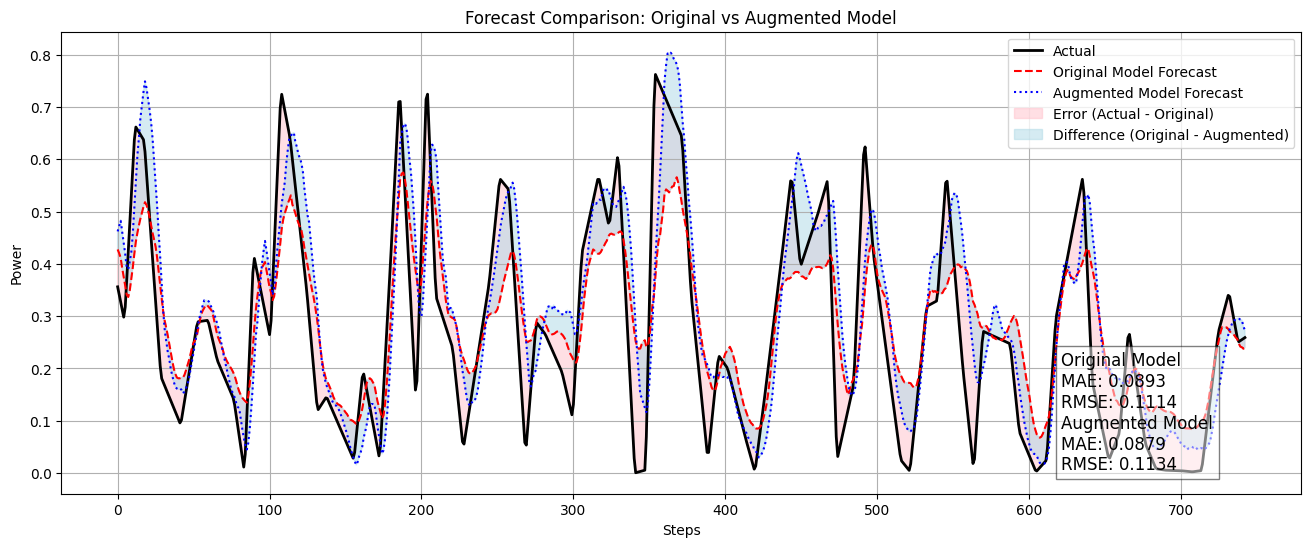

Original Model - MSE: 0.0389, MAE: 0.1657, RMSE: 0.1973
Augmented Model - MSE: 0.0336, MAE: 0.1413, RMSE: 0.1834


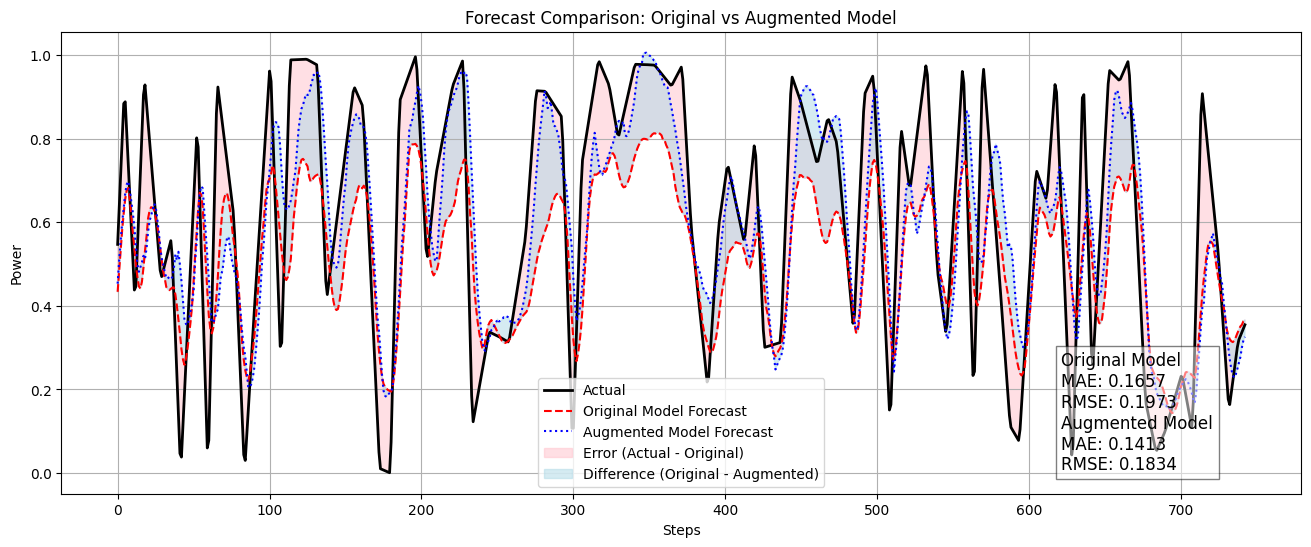

Original Model - MSE: 0.0177, MAE: 0.1068, RMSE: 0.1331
Augmented Model - MSE: 0.0198, MAE: 0.1095, RMSE: 0.1408


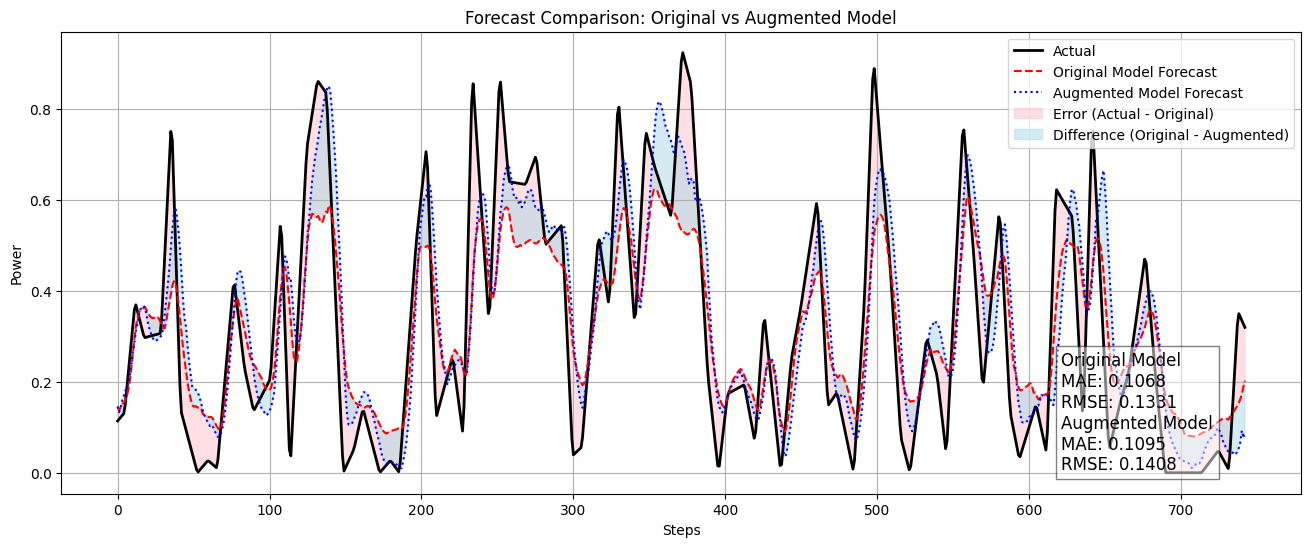

In [16]:
print("\nEvaluating PatchTST on test data...")
evaluate_two_models(model_orig=model_patchtst,model_aug=model_patchtst_aug, scaler= scaler_patchtst_aug, X_test=X_test, y_test= y_test,features= features, seq_len=seq_len, forecast_horizon=forecast_horizon, patch_len=patch_len, start_point=7991, end_point=8734)
evaluate_two_models(model_orig=model_patchtst,model_aug= model_patchtst_aug, scaler= scaler_patchtst_aug,X_test= X_test,y_test= y_test,features= features, seq_len=seq_len, forecast_horizon=forecast_horizon, patch_len=patch_len, start_point=16726, end_point=17469)
evaluate_two_models(model_orig=model_patchtst,model_aug= model_patchtst_aug, scaler= scaler_patchtst_aug, X_test=X_test,y_test= y_test,features= features,seq_len= seq_len, forecast_horizon=forecast_horizon, patch_len=patch_len, start_point=25461, end_point=26204)
evaluate_two_models(model_orig=model_patchtst,model_aug= model_patchtst_aug, scaler= scaler_patchtst_aug, X_test=X_test,y_test= y_test,features= features,seq_len= seq_len, forecast_horizon= forecast_horizon, patch_len=patch_len, start_point=34196, end_point=34939)


In [17]:
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import torch
import math 

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / np.clip(denominator, 1e-8, None)) * 100


def evaluate_monthly_timemoe_errors(
    model_orig, model_aug, 
    scaler_X, y_train_org,
    X_test, y_test, features,
    seq_len, forecast_horizon
):
    # Prepare index
    X_test = X_test.copy()
    X_test.index = pd.to_datetime(X_test.index)
    y_test.index = X_test.index

    # Scale full test set
    X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), index=X_test.index, columns=features)

    # Inverse scaler for target
    y_scaler = StandardScaler().fit(y_train_org.values.reshape(-1, 1))

    # Location slicing
    total_len = len(X_test)
    n_locations = 4
    loc_size = total_len // n_locations

    results = []

    for loc in range(n_locations):
        start_idx = loc * loc_size
        end_idx = (loc + 1) * loc_size

        # Data for this location
        X_loc = pd.DataFrame(X_test_scaled.iloc[start_idx:end_idx])
        y_loc = y_test.iloc[start_idx:end_idx]

        for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
            y_month = y_loc[df_month.index]

            if len(df_month) < seq_len + 1:
                continue

            # Create sequences
            X_seq, y_seq = create_sequences(df_month[features],y_month, seq_len,forecast_horizon)
            if len(X_seq) == 0:
                continue

            X_tensor = torch.tensor(X_seq, dtype=torch.float32)

            # Predict
            with torch.no_grad():
                model_orig.eval()
                model_aug.eval()
                preds_orig = model_orig(X_tensor).numpy()
                preds_aug = model_aug(X_tensor).numpy()

            # Desequence all
            merged_pred_org = desequence(preds_orig, seq_len, forecast_horizon)
            merged_pred_aug = desequence(preds_aug, seq_len, forecast_horizon)
            merged_true = desequence(y_seq, seq_len, forecast_horizon)

            # Inverse transform
            y_true = y_scaler.inverse_transform(merged_true.reshape(-1, 1)).flatten()
            preds_orig_inv = y_scaler.inverse_transform(merged_pred_org.reshape(-1, 1)).flatten()
            preds_aug_inv = y_scaler.inverse_transform(merged_pred_aug.reshape(-1, 1)).flatten()

            # Compute metrics
            results.append({
                'location': f'Location_{loc+1}',
                'month': month.strftime('%Y-%m'),
                'mae_org': mean_absolute_error(y_true, preds_orig_inv),
                'rmse_org': math.sqrt(mean_squared_error(y_true, preds_orig_inv)),
                'mape_org': mape(y_true, preds_orig_inv),
                'smape_org': smape(y_true, preds_orig_inv),
                'r2_org': r2_score(y_true, preds_orig_inv),
                'mae_aug': mean_absolute_error(y_true, preds_aug_inv),
                'rmse_aug': math.sqrt(mean_squared_error(y_true, preds_aug_inv)),
                'mape_aug': mape(y_true, preds_aug_inv),
                'smape_aug': smape(y_true, preds_aug_inv),
                'r2_aug': r2_score(y_true, preds_aug_inv)
            })

    results_df = pd.DataFrame(results)

    # Monthly average + std across 4 locations
    monthly_summary = results_df.groupby('month').agg({
        'mae_org': ['mean', 'std'],
        'rmse_org': ['mean', 'std'],
        'mape_org': ['mean', 'std'],
        'smape_org': ['mean', 'std'],
        'r2_org': ['mean', 'std'],
        'mae_aug': ['mean', 'std'],
        'rmse_aug': ['mean', 'std'],
        'mape_aug': ['mean', 'std'],
        'smape_aug': ['mean', 'std'],
        'r2_aug': ['mean', 'std'],
    }).reset_index()

    monthly_summary.columns = ['month'] + [f"{col[0]}_{col[1]}" for col in monthly_summary.columns[1:]]

    return results_df, monthly_summary


In [18]:
results_df, monthly_summary = evaluate_monthly_timemoe_errors(
    model_orig=model_patchtst,
    model_aug=model_patchtst_aug,
    scaler_X=scaler_patchtst_aug,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    features=features,
    seq_len=seq_len,
    forecast_horizon=forecast_horizon
)


/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_4454/394341733.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_4454/394341733.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_4454/394341733.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_4454/394341733.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):


In [19]:
final_results = []

for loc in results_df['location'].unique():
    loc_data = results_df[results_df['location'] == loc]
    final_results.append({
        'Location': loc,
        'mae_org': f"{loc_data['mae_org'].mean():.4f}  ± {loc_data['mae_org'].std():.4f}",
        'rmse_org': f"{loc_data['rmse_org'].mean():.4f}  ± {loc_data['rmse_org'].std():.4f}",
        'mape_org': f"{loc_data['mape_org'].mean():.4f}  ± {loc_data['mape_org'].std():.4f}",
        'smape_org': f"{loc_data['smape_org'].mean():.4f}  ± {loc_data['smape_org'].std():.4f}",
        'r2_org': f"{loc_data['r2_org'].mean():.4f}  ± {loc_data['r2_org'].std():.4f}",
        'mae_aug': f"{loc_data['mae_aug'].mean():.4f}  ± {loc_data['mae_aug'].std():.4f}",
        'rmse_aug': f"{loc_data['rmse_aug'].mean():.4f}  ± {loc_data['rmse_aug'].std():.4f}",
        'mape_aug': f"{loc_data['mape_aug'].mean():.4f}  ± {loc_data['mape_aug'].std():.4f}",
        'smape_aug': f"{loc_data['smape_aug'].mean():.4f}  ± {loc_data['smape_aug'].std():.4f}",
        'r2_aug': f"{loc_data['r2_aug'].mean():.4f}  ± {loc_data['r2_aug'].std():.4f}",
    })

final_results.append({
    'Location': 'All Location Combined',
    'mae_org': f"{results_df['mae_org'].mean():.4f}  ± {results_df['mae_org'].std():.4f}",
    'rmse_org': f"{results_df['rmse_org'].mean():.4f}  ± {results_df['rmse_org'].std():.4f}",
    'mape_org': f"{results_df['mape_org'].mean():.4f}  ± {results_df['mape_org'].std():.4f}",
    'smape_org': f"{results_df['smape_org'].mean():.4f}  ± {results_df['smape_org'].std():.4f}",
    'r2_org': f"{results_df['r2_org'].mean():.4f}  ± {results_df['r2_org'].std():.4f}",
    'mae_aug': f"{results_df['mae_aug'].mean():.4f}  ± {results_df['mae_aug'].std():.4f}",
    'rmse_aug': f"{results_df['rmse_aug'].mean():.4f}  ± {results_df['rmse_aug'].std():.4f}",
    'mape_aug': f"{results_df['mape_aug'].mean():.4f}  ± {results_df['mape_aug'].std():.4f}",
    'smape_aug': f"{results_df['smape_aug'].mean():.4f}  ± {results_df['smape_aug'].std():.4f}",
    'r2_aug': f"{results_df['r2_aug'].mean():.4f}  ± {results_df['r2_aug'].std():.4f}",
})
final_results =  pd.DataFrame(final_results)

In [20]:
final_results

,Location,mae_org,rmse_org,mape_org,smape_org,r2_org,mae_aug,rmse_aug,mape_aug,smape_aug,r2_aug
0,Location_1,0.0266 ± 0.0052,0.0336 ± 0.0063,6.1199 ± 0.8033,6.1824 ± 0.8656,0.7812 ± 0.0336,0.0257 ± 0.0042,0.0335 ± 0.0055,6.0167 ± 0.6925,6.0890 ± 0.6870,0.7803 ± 0.0376
1,Location_2,0.0213 ± 0.0031,0.0263 ± 0.0044,5.9020 ± 0.6326,5.7809 ± 0.6365,0.6134 ± 0.0678,0.0206 ± 0.0050,0.0273 ± 0.0061,5.6156 ± 1.1691,5.5133 ± 1.1111,0.5924 ± 0.0628
2,Location_3,0.0264 ± 0.0099,0.0316 ± 0.0119,6.7790 ± 1.3904,6.7142 ± 1.5392,-0.4361 ± 3.1927,0.0205 ± 0.0090,0.0271 ± 0.0117,5.2463 ± 1.7827,5.1952 ± 1.7526,0.5060 ± 0.3931
3,Location_4,0.0218 ± 0.0049,0.0278 ± 0.0062,5.6433 ± 0.9335,5.6156 ± 0.9751,0.7140 ± 0.0754,0.0204 ± 0.0042,0.0268 ± 0.0053,5.2990 ± 0.9024,5.2637 ± 0.8627,0.7164 ± 0.1206
4,All Location Combined,0.0240 ± 0.0066,0.0298 ± 0.0081,6.1111 ± 1.0402,6.0733 ± 1.1092,0.4181 ± 1.6249,0.0218 ± 0.0062,0.0287 ± 0.0079,5.5444 ± 1.2095,5.5153 ± 1.1912,0.6487 ± 0.2290


In [21]:
monthly_summary

,month,mae_org_mean,mae_org_std,rmse_org_mean,rmse_org_std,mape_org_mean,mape_org_std,smape_org_mean,smape_org_std,r2_org_mean,...,mae_aug_mean,mae_aug_std,rmse_aug_mean,rmse_aug_std,mape_aug_mean,mape_aug_std,smape_aug_mean,smape_aug_std,r2_aug_mean,r2_aug_std
0,2021-01,0.023343,0.003972,0.028787,0.005076,6.186793,0.895650,6.094797,0.852591,0.673750,...,0.019797,0.005363,0.026656,0.006790,5.120563,0.960308,5.120051,1.040715,0.721628,0.138865
1,2021-02,0.022862,0.005547,0.029363,0.007976,5.888417,0.663836,5.837767,0.737137,0.648742,...,0.020575,0.004886,0.027975,0.006331,5.278315,0.684517,5.246744,0.740848,0.672318,0.120445
2,2021-03,0.027584,0.007684,0.033740,0.009882,6.842042,0.944938,6.822713,1.090053,0.641945,...,0.023729,0.007685,0.030869,0.009373,5.954427,1.162108,5.895858,1.211171,0.698628,0.095046
3,2021-04,0.024105,0.002007,0.030825,0.003326,6.176442,0.264263,6.145219,0.170382,0.637832,...,0.024661,0.002430,0.032088,0.003263,6.276812,0.057031,6.271776,0.117022,0.606211,0.101885
4,2021-05,0.019736,0.001631,0.024941,0.002738,5.297138,0.299968,5.237779,0.276725,0.634471,...,0.019151,0.004421,0.024738,0.005373,5.036645,0.842751,5.042762,0.859738,0.672694,0.156137
5,2021-06,0.021401,0.002706,0.026360,0.005275,5.842979,0.252731,5.758649,0.242551,0.433688,...,0.016603,0.004786,0.022249,0.006182,4.427496,0.865981,4.440632,0.921398,0.664563,0.227463
6,2021-07,0.017620,0.002561,0.021426,0.003435,5.024630,0.807781,4.918447,0.767312,-2.108524,...,0.016005,0.007220,0.020615,0.009016,4.377482,1.765109,4.394914,1.773121,0.280596,0.635919
7,2021-08,0.018598,0.002284,0.022863,0.003310,5.267520,0.481468,5.155744,0.488650,0.610933,...,0.017614,0.004551,0.023422,0.005694,4.874057,1.173935,4.820565,1.104564,0.601462,0.140747
8,2021-09,0.023486,0.003669,0.029266,0.004473,6.048361,0.778128,5.999141,0.764566,0.713326,...,0.022197,0.003078,0.029468,0.003755,5.704509,0.658044,5.656233,0.628482,0.704723,0.114380
9,2021-10,0.026197,0.007328,0.032954,0.009698,6.364570,1.196663,6.395182,1.291718,0.771024,...,0.023298,0.004962,0.030969,0.006943,5.741382,1.066165,5.762536,1.047016,0.784680,0.085519


In [22]:
FOLDER_NAME = './Results/PatchTST'
os.makedirs(FOLDER_NAME, exist_ok=True)
final_results.to_csv(os.path.join(FOLDER_NAME,"final_results.csv"), index=False)
monthly_summary.to_csv(os.path.join(FOLDER_NAME,"monthly_summary.csv"), index=False)